This notebook is meant to serve as an example of how I did hyperparameter tuning. The full set of tested hyperparameters and model architectures tested can be viewed in the folder "hyperparam_tuning_notebooks".

A lot of the code for setting up the model is either taken from or inspired by this blog post: https://heartbeat.fritz.ai/build-train-and-deploy-a-book-recommender-system-using-keras-tensorflow-js-b96944b936a7

Hyperparameter tuning method is adapted from here: https://www.tensorflow.org/tensorboard/hyperparameter_tuning_with_hparams

### Imports

In [1]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt

### Data prep

note: This is not the final dataset used

In [5]:
ratings = pd.read_pickle("./Data/small_random_selection_longform.pkl")
ratings2 = pd.read_pickle("./Data/small_random_selection_longform_2.pkl")

In [6]:
len(ratings), len(ratings2)

(555154, 555847)

In [11]:
ratings = pd.concat([ratings, ratings2])

In [14]:
ratings.shape

(1111001, 3)

In [16]:
ratings.drop(index=ratings[ratings.duplicated(keep='first')].index, inplace=True)

Generate labels for user and movie data to use in the model

In [17]:
user_enc = LabelEncoder()
ratings['user'] = user_enc.fit_transform(ratings['user_id'].values)
n_users = ratings['user'].nunique()

item_enc = LabelEncoder()
ratings['movie'] = item_enc.fit_transform(ratings['movie_id'].values)
n_movies = ratings['movie'].nunique()

nmovie_id = ratings.movie_id.nunique()
nuser_id = ratings.user_id.nunique()

n_users, n_movies

(44012, 37296)

train test split

In [18]:
X_train, X_test = train_test_split(ratings[['movie', 'user', 'rating_score']], test_size=0.3, random_state=42)

In [19]:
len(X_train)

650510

### Train the models

Hyperparameters to test:

In [56]:
HP_NUM_UNITS = [32, 128]
HP_DROPOUT = [.3, .4]
HP_LEARNING_RATE = [.01, .1]
HP_REGULARIZER = ['l2']

In [57]:
def train_test_model(hparams):
    
    input_movies = keras.layers.Input(shape=[1])
    embed_movies = keras.layers.Embedding(nmovie_id+1, 15)(input_movies)
    movies_out = keras.layers.Flatten()(embed_movies)

    input_users = keras.layers.Input(shape=[1])
    embed_users = keras.layers.Embedding(nuser_id+1, 15)(input_users)
    users_out = keras.layers.Flatten()(embed_users)

    conc_layer = keras.layers.Concatenate()([movies_out, users_out])
    x = keras.layers.Dense(hparams['HP_NUM_UNITS'], 
                           activation='relu', 
                           kernel_regularizer=hparams['HP_REGULARIZER'])(conc_layer)
    dropout = x = keras.layers.Dropout(rate=hparams['HP_DROPOUT'], seed=42)(x)
    x_out = x = keras.layers.Dense(1, 
                                   activation='relu',
                                  kernel_regularizer=hparams['HP_REGULARIZER'])(x)

    model = keras.Model([input_movies, input_users], x_out)
    
    opt = tf.optimizers.Adam(learning_rate=hparams['HP_LEARNING_RATE'])
    model.compile(optimizer=opt, loss='mean_squared_error', metrics = keras.metrics.RootMeanSquaredError())
    
    hist = model.fit([X_train.movie, X_train.user], 
                 X_train.rating_score,  
                 batch_size=len(X_train), epochs=100, validation_split=.2)

    return hist, model

In [ ]:
run_history = {}
models = []

session_num = 0

for num_units in HP_NUM_UNITS:
    for dropout_rate in HP_DROPOUT:
        for learning_rate in HP_LEARNING_RATE:
            for regularization in HP_REGULARIZER:
                hparams = {
                'HP_NUM_UNITS': num_units,
                'HP_DROPOUT': dropout_rate,
                'HP_LEARNING_RATE': learning_rate,
                'HP_REGULARIZER': regularization,
                }
                
                run_name = "run-{}".format(session_num)
                print("----Starting trial: {}".format(run_name))
                print(hparams)
                
                output, model = train_test_model(hparams,)
                run_history[run_name] = {
                    'params': hparams,
                    'output': output,
                }
                models.append(model)
                session_num += 1

(output from above cleared for better readability)

### Evaluate results

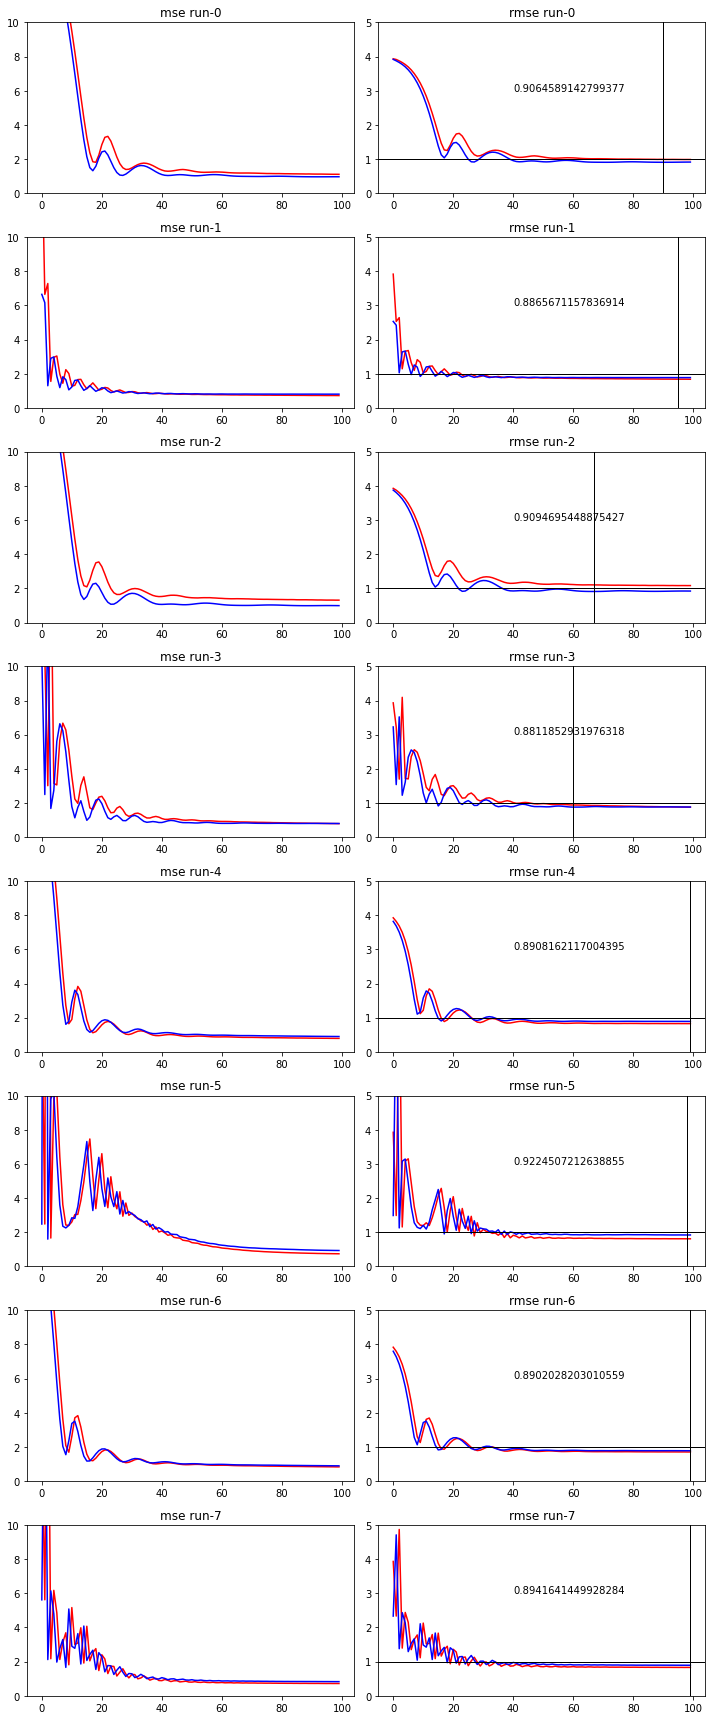

In [60]:
fig, axs = plt.subplots(ncols=2, nrows=len(run_history.keys()), figsize=(10, len(run_history.keys())*3))

for n, key in enumerate(run_history.keys()):
    axs[n,0].plot(run_history[key]['output'].history['loss'], color='r')
    axs[n,0].plot(run_history[key]['output'].history['val_loss'], color='b')
    
    axs[n,1].plot(run_history[key]['output'].history['root_mean_squared_error'], color='r')
    axs[n,1].plot(run_history[key]['output'].history['val_root_mean_squared_error'], color='b')
    axs[n,1].axvline(np.where(run_history[key]['output'].history['val_root_mean_squared_error']==np.min(run_history[key]['output'].history['val_root_mean_squared_error'])), 
                     color='k', lw=1)
    axs[n,1].annotate(str(np.min(run_history[key]['output'].history['val_root_mean_squared_error'])),
                        xy=(40,3),)
    
#     title_str = '-'.join(str(run_history[key]['params'][param]) for param in run_history[key]['params'].keys(),
#                         xytext=(.8,.8), xycoords='subfigure fraction')
    
    axs[n,0].set_title("mse {}".format(key))
    axs[n,1].set_title("rmse {}".format(key))
    
    axs[n,0].set_ylim(0,10)
    axs[n,1].set_ylim(0,5)
    
    axs[n, 1].axhline(1, color='k', lw=1)
    
plt.tight_layout()   
plt.show()

In [62]:
# print(run_history['run-0'])
print(run_history['run-1'])
# print(run_history['run-2'])
print(run_history['run-3'])
print(run_history['run-6'])

{'params': {'HP_NUM_UNITS': 32, 'HP_DROPOUT': 0.3, 'HP_LEARNING_RATE': 0.1, 'HP_REGULARIZER': 'l2'}, 'output': <tensorflow.python.keras.callbacks.History object at 0x7f181a1869d0>}
{'params': {'HP_NUM_UNITS': 32, 'HP_DROPOUT': 0.4, 'HP_LEARNING_RATE': 0.1, 'HP_REGULARIZER': 'l2'}, 'output': <tensorflow.python.keras.callbacks.History object at 0x7f1819da2e50>}
{'params': {'HP_NUM_UNITS': 128, 'HP_DROPOUT': 0.4, 'HP_LEARNING_RATE': 0.01, 'HP_REGULARIZER': 'l2'}, 'output': <tensorflow.python.keras.callbacks.History object at 0x7f18107d0a90>}


Manually inspect accuracy for single user

In [30]:
user_id = 44117354
ratings[ratings.user_id==user_id]

,movie_id,rating_score,user_id,user,movie
3675,830,4,44117354,19690,759
9918,31747,3,44117354,19690,13001
16199,133823,2,44117354,19690,30304
44079,26024,2,44117354,19690,9692
59731,93537,5,44117354,19690,23232
...,...,...,...,...,...
578048,45023,5,44117354,19690,18491
622495,27447,4,44117354,19690,10569
634079,147,3,44117354,19690,111
668979,197,1,44117354,19690,160


In [31]:
user = 19690

In [32]:
movie_array = ratings[ratings.user_id==user_id].movie.values.astype(int)
user = np.array([int(user) for n in range(len(movie_array))])

In [37]:
pred = model.predict([movie_array, user])

In [38]:
list(zip(zip(pred.flatten(), ratings[ratings.user_id==user_id].rating_score.values),movie_array))

[((4.443749, 4), 759),
 ((3.0487213, 3), 13001),
 ((3.4955826, 2), 30304),
 ((4.2365317, 2), 9692),
 ((4.620772, 5), 23232),
 ((4.2911863, 5), 113),
 ((4.0627294, 5), 108),
 ((3.4778192, 3), 4704),
 ((3.7692504, 5), 2531),
 ((3.6930926, 4), 26290),
 ((3.4296114, 2), 1485),
 ((4.2770286, 4), 2103),
 ((3.4494987, 3), 10623),
 ((3.7676442, 5), 11182),
 ((4.4641213, 5), 903),
 ((3.811058, 5), 32392),
 ((3.9964552, 4), 17994),
 ((4.216799, 5), 32233),
 ((3.507463, 3), 3041),
 ((3.8077025, 3), 27185),
 ((2.762479, 4), 27443),
 ((4.434957, 5), 25895),
 ((4.169401, 2), 8461),
 ((3.0923502, 2), 3107),
 ((3.6240742, 4), 4452),
 ((4.223429, 5), 273),
 ((3.3390841, 3), 9604),
 ((4.2326694, 5), 22203),
 ((3.0539048, 3), 35191),
 ((4.018703, 5), 11221),
 ((3.3099916, 2), 1647),
 ((3.6017835, 5), 2883),
 ((3.4528334, 3), 3043),
 ((3.611532, 4), 5636),
 ((3.4521797, 4), 30965),
 ((3.3492951, 3), 1683),
 ((4.351111, 5), 9463),
 ((3.7766812, 3), 152),
 ((4.351217, 5), 814),
 ((3.9190128, 5), 12551),
 ((

In [52]:
def is_close_enough(pred, ratings):
    val = []
    for pair in zip(pred, ratings):
        val.append(pair[1] - .5 <= pair[0] <= pair[1] + .5)
        
    return val

In [53]:
val = is_close_enough(np.round(pred.flatten(), 1), ratings[ratings.user_id==user_id].rating_score.values)

A rough accuracy score. Obviously this is not great.

In [55]:
sum(val) / len(pred.flatten())

0.3963963963963964

Save the test information.

In [ ]:
import json
def export_history(run_history, batch_size, n_epochs, save_path):
    history_dict = run_history.copy()
    for key in history_dict:
        if history_dict[key]['params']['HP_REGULARIZER']=='l2':
            
            history_dict[key]['params']['HP_REGULARIZER'] = .01
        else:
            try:
                history_dict[key]['params']['HP_REGULARIZER'] = history_dict[key]['params']['HP_REGULARIZER'].l2.tolist()
            except:
                pass   
        if type(history_dict[key]['params']['HP_REGULARIZER']) == np.ndarray:
            history_dict[key]['params']['HP_REGULARIZER'] = history_dict[key]['params']['HP_REGULARIZER'].tolist()
        history_dict[key]['params']['batch_size'] = batch_size
        history_dict[key]['params']['n_epochs'] = n_epochs
        
        try:
            history_dict[key]['output'] = history_dict[key]['output'].history
        except:
            history_dict[key]['output'] = history_dict[key]['output']
      
    with open(save_path, 'w') as f:
        json.dump(history_dict, f)
    
    return history_dict

new_dict = export_history(run_history, 10000, 10, "./run_history/model9.json")